Simple regression with pytorch

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Assume that observation (x,y) has a form y = 3x + 5 + C, where the noise term C has a distribution C ~ N(0, s^2)

In [2]:
n_samples = 500
x_data = np.random.randn(n_samples, 1).flatten()
eps = np.random.normal(0.0, 1.0, n_samples)
y_data = 3*x_data + 5 + eps
data = pd.DataFrame({"x_data": x_data,
                     "y_data": y_data})

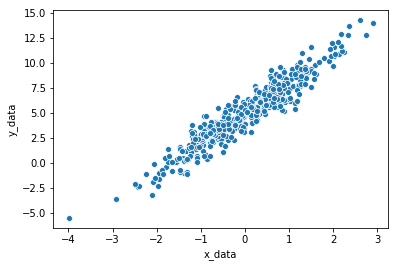

In [3]:
sns.scatterplot(x="x_data",
                y="y_data",
                data=data)

In [4]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(data["x_data"], data["y_data"])
print(slope, intercept)

2.9459294438756602 5.005528090492117


Our purpose is to estimate the equation that explains the graph in the best way.

# DATALOADER

In [5]:
from torch.utils.data import Dataset, DataLoader

class LRDataset(Dataset):
    def __init__(self, x_data, y_data):
        super(LRDataset, self).__init__()
        
        self.x = x_data
        self.y = y_data
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x
        y = self.y
        return x[idx], y[idx]

In [6]:
def dictionary_dataset(x, y, num_samples):
    train_num = int(num_samples * 0.8)
    train_x, test_x = x[:train_num], x[:train_num]
    train_y, test_y = y[:train_num], y[:train_num]
    train_dataset = LRDataset(train_x, train_y)
    test_dataset = LRDataset(test_x, test_y)
    partition = {"train": train_dataset, "test": test_dataset}
    
    return partition

In [7]:
partition_dictionary = dictionary_dataset(x_data, y_data, 500)
print(partition_dictionary)

{'train': <__main__.LRDataset object at 0x000001DD9594BBA8>, 'test': <__main__.LRDataset object at 0x000001DD9594BAC8>}


# MODEL

In [8]:
import torch.nn as nn
import torch.nn.functional as F

torch.set_default_dtype(torch.double)

class LR(nn.Module):
    def __init__(self, input_size, output_size):
        super(LR, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.fc = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, x):
        res = self.fc(x)
        return res

# EXPERIMENT

In [9]:
def train(model, criteria, batch_size, dataset):
    model.train()
    optimizer = torch.optim.Adam(model.parameters())
    train_loss = 0.0
    for i, batch in enumerate(dataset):
        x_batch = (batch[0].clone().detach().requires_grad_(True)).view(-1)
        y_batch = (batch[1].clone().detach().requires_grad_(True)).view(-1)
        y_pred = model(x_batch)
        loss = criteria(y_pred, y_batch)
        train_loss += loss.item()/len(dataset)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model, train_loss

In [10]:
def test(model, criteria, batch_size, dataset):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(dataset):
            x_batch = (batch[0].clone().detach().requires_grad_(True)).view(-1)
            y_batch = (batch[1].clone().detach().requires_grad_(True)).view(-1)
            y_pred = model(x_batch)
            loss = criteria(y_pred, y_batch)
            test_loss += loss.item()/len(dataset)
        
    return model, test_loss

In [11]:
def confirm(model):
    x_test = np.random.randn(100, 1).flatten()
    num_test_batches = x_test.shape[0] // 10
    y_test = []
    for i in range(num_test_batches):
        x_batch = x_test[i*10:(i+1)*10]
        y_test_batch = []
        for j in range(len(x_batch)):
            y_test_batch.append(model(torch.tensor(x_batch[j]).view(-1)).item())
        y_test.append(y_test_batch)
    y_test = np.asarray(y_test).flatten()

    data = pd.DataFrame({"x_test": x_test,
                         "y_test": y_test})

    return data

In [12]:
def experiment(num_epoch, batch_size, partition_dictionary):
    model = LR(batch_size, batch_size)
    criteria = nn.MSELoss()
    
    train_dataset = DataLoader(partition_dictionary["train"],
                               batch_size = batch_size,
                               shuffle = True)
    test_dataset = DataLoader(partition_dictionary["test"],
                               batch_size = batch_size,
                               shuffle = True)
    
    train_loss_list = []
    test_loss_list = []
    max_loss = 0.0
    min_loss = 0.0
    epoch_list = []
    for epoch in range(num_epoch):
        model, train_loss = train(model, criteria, batch_size, train_dataset)
        _, test_loss = test(model, criteria, batch_size, test_dataset)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        
        bigger_loss = train_loss if train_loss > test_loss else test_loss
        smaller_loss = train_loss if train_loss < test_loss else test_loss
        
        max_loss = train_loss if bigger_loss > max_loss else max_loss
        min_loss = train_loss if smaller_loss < min_loss else min_loss
        
        epoch_list.append(epoch)
        
    loss_range = [i*(max_loss - min_loss)/len(epoch_list) for i in range(len(epoch_list))]
    
    ret_DF = pd.DataFrame({"epoch": epoch_list * 2,
                           "loss type": ["train" for i in range(len(train_loss_list))] + ["test" for i in range(len(test_loss_list))],
                           "loss value": train_loss_list + test_loss_list})
    
    print(model.fc.weight.data.numpy(), model.fc.bias.data.numpy())
    
    confirm_DF = confirm(model)
        
    return ret_DF, confirm_DF

# VISUALIZATION

In [13]:
result_data, confirm_data = experiment(20, 1, partition_dictionary)

[[2.89403391]] [4.97605506]


In [14]:
print(result_data)

    epoch loss type  loss value
0       0     train   24.355977
1       1     train   21.032843
2       2     train   17.882072
3       3     train   15.086491
4       4     train   12.634967
5       5     train   10.360020
6       6     train    8.325053
7       7     train    6.604453
8       8     train    5.138126
9       9     train    3.939376
10     10     train    2.946953
11     11     train    2.207615
12     12     train    1.707709
13     13     train    1.362161
14     14     train    1.155020
15     15     train    1.040250
16     16     train    0.979755
17     17     train    0.953586
18     18     train    0.939226
19     19     train    0.933082
20      0      test   22.653958
21      1      test   19.448187
22      2      test   16.418442
23      3      test   13.785330
24      4      test   11.497983
25      5      test    9.313744
26      6      test    7.422996
27      7      test    5.845795
28      8      test    4.498211
29      9      test    3.428125
30     1

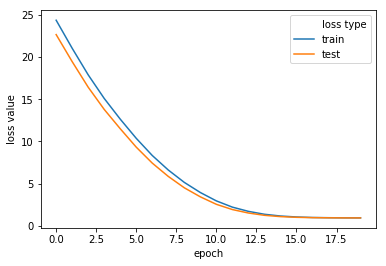

In [15]:
g = sns.lineplot(x="epoch", y="loss value", hue="loss type", data=result_data)

2.8940339139848725 4.976055058067029


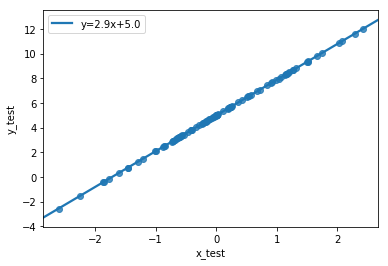

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(confirm_data["x_test"], confirm_data["y_test"])
print(slope, intercept)

ax = sns.regplot(x="x_test",
                 y="y_test",
                 data=confirm_data,
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope, intercept)})
ax.legend()